In [27]:
import numpy as np
import torch
import matplotlib.pyplot as pl
import ot
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import os
from pathlib import Path

In [28]:
import sys
from SWGG import SWGG_parallel
from utils import sort_to_plan
from generate_data import make_data

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


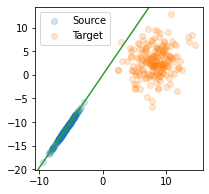

In [30]:
n=200
dim=3
xs,xt=make_data('gaussians',n,dim)

gray_theta = torch.tensor([0.3, 0.59, 0.11])
gray_theta=gray_theta/torch.norm(gray_theta)

X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)
X=X.float()
X_line=torch.matmul(X,gray_theta)
X=X_line[:,None]@gray_theta[None,:]
Y=Y.float()
#Y_line=torch.matmul(Y,gray_theta)
#Y=Y_line[:,None]@gray_theta[None,:]

pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.2)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.2)
pl.axline((0,0), [gray_theta[0],gray_theta[1]], color='C2')
pl.legend(loc=2)

In [31]:
ns=X.shape[0]
nt=Y.shape[0]
a, b = torch.ones((ns,))/ns, torch.ones((nt,))/nt
#The exact Wasserstein distance
C=ot.dist(X,Y)
print('W = ',ot.emd2(a,b,C))

W =  tensor(429.6194)


In [32]:
W,u,v=SWGG_parallel(X,Y,gray_theta.reshape(3,1))
P=sort_to_plan(u[:,0],v[:,0])
print('SWGG = ',W)

SWGG =  tensor([429.6194])


# Colorization

In [46]:
def transform(Xs,xs,xt,P,batch_size=128): #xs xt training and Xs Xt all

    # perform out of sample mapping
    indices = torch.arange(Xs.shape[0])
    batch_ind = [
        indices[i:i + batch_size]
        for i in range(0, len(indices), batch_size)]

    transp_Xs_l = []
    
    for bi in batch_ind:
        # get the nearest neighbor in the source domain
        D0 = ot.dist(Xs[bi], xs)
        idx = torch.argmin(D0, axis=1)

        # transport the source samples
        transp = P/ torch.sum(P, axis=1)[:, None]
        transp[~ torch.isfinite(transp)] = 0
        
        #print(transp.shape)
        transp_Xs = torch.matmul(transp, xt) #Barycentric Projection 

        # define the transported points
        transp_Xs = transp_Xs[idx, :]#+ Xs[bi] - xs[idx, :]
        transp_Xs_l.append(transp_Xs)

    transp_Xs_l = torch.concatenate(transp_Xs_l, axis=0)

    return transp_Xs_l

In [36]:
def random_subsample(X1,X2,nb=200):
    idx1 = torch.randint(X1.shape[0], size=(nb,))
    idx2 = torch.randint(X2.shape[0], size=(nb,))
    xs = X1[idx1, :]
    xt = X2[idx2, :]
    return xs,xt

def minibatch_kmeans_subsample(X1,X2,nb=200,batch_size=5000,max_iter=300):
    kmeans = MiniBatchKMeans(n_clusters=nb,random_state=0,batch_size=batch_size,max_iter=max_iter).fit(X1)
    xs=torch.tensor(kmeans.cluster_centers_)
    kmeans = MiniBatchKMeans(n_clusters=nb,random_state=0,batch_size=batch_size,max_iter=max_iter).fit(X2)
    xt=torch.tensor(kmeans.cluster_centers_)
    return xs,xt

In [37]:
gray_theta = torch.tensor([150/256, 150/256, 150/256])

/home/gui/Documents/Thèse/SWGG/Expe/Color Transfert/data/Images


Text(0.5, 1.0, 'Image 2')

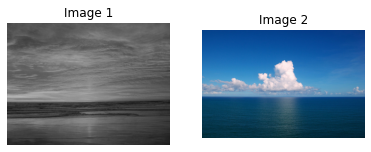

In [38]:
# Loading images
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent, 'data/Images')
#data_path = os.path.join(Path(this_file).parent)
print(data_path)
I1 = pl.imread(os.path.join(data_path, 'ocean_sunset.jpg')).astype(np.float64) / 256
I2 = pl.imread(os.path.join(data_path, 'ocean_day.jpg')).astype(np.float64) / 256

X1 = torch.tensor(I1.reshape((I1.shape[0] * I1.shape[1], I1.shape[2])))
X_line=torch.matmul(X1.float(),gray_theta)
X1=X_line[:,None]@gray_theta[None,:]
I1=torch.clip(X1.reshape(I1.shape),0,1)
X2 = torch.tensor(I2.reshape((I2.shape[0] * I2.shape[1], I2.shape[2])))

pl.figure(1, figsize=(6.4, 3))
pl.subplot(1, 2, 1)
pl.imshow(I1)
pl.axis('off')
pl.title('Image 1')

pl.subplot(1, 2, 2)
pl.imshow(I2)
pl.axis('off')
pl.title('Image 2')

In [40]:
X,Y=random_subsample(X1,X2,nb=10000)
#X,Y= minibatch_kmeans_subsample(X1,X2,nb=5000,batch_size=50,max_iter=300)

Text(0.5, 1.0, 'Image 2')

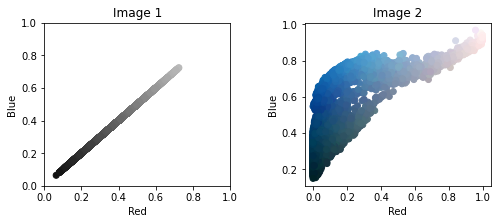

In [41]:
pl.figure(figsize=(8,3))
grid = pl.GridSpec(1, 2, wspace=0.4, hspace=0.3)

pl.subplot(grid[0, 0])
pl.scatter(X[:, 0], X[:, 2], c=X)
pl.axis([0, 1, 0, 1])
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 1')

pl.subplot(grid[0, 1])
pl.scatter(Y[:, 0], Y[:, 2], c=Y)
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 2')

Text(0.5, 0.92, 'Image 2')

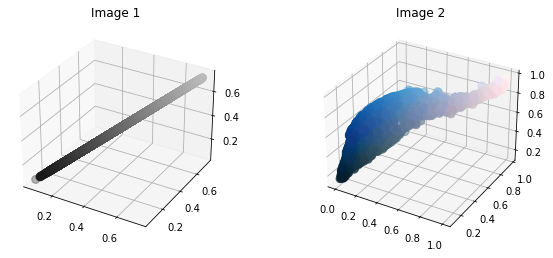

In [65]:
size=size = X.shape[0]*[64]

fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
pl.scatter(X[:,0],X[:,1],zs=X[:,2],s=size,c=X)
pl.title('Image 1')

ax = fig.add_subplot(122, projection='3d')
pl.scatter(Y[:,0],Y[:,1],zs=Y[:,2],s=size,c=Y)
pl.title('Image 2')

In [42]:
#If the theta is not known

#pca = PCA(n_components=1).fit(X)
#gray_theta=torch.tensor(pca.components_[0]).float()

In [43]:
X=X.float()
Y=Y.float()

_,u,v=SWGG_parallel(X,Y,gray_theta.reshape(3,1))
P=sort_to_plan(u[:,0],v[:,0])

#C=ot.dist(X,Y)
#n=X.shape[0]
#a,b=torch.ones((n,))/n,torch.ones((n,))/n
#P=ot.emd(a,b,C,numItermax=1000000)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [50]:
transp_Xs=transform(X1.float(),X,Y,P,batch_size=10000)
I1_colorized=torch.clip(transp_Xs.reshape(I1.shape),0,1)

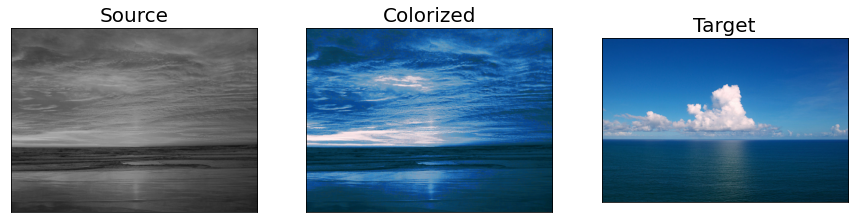

In [51]:
f, ax = pl.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(I1)
ax[1].imshow(I1_colorized)
ax[2].imshow(I2)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Colorized', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
pl.show()